In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM

In [3]:
pip install pandas_datareader

     |████████████████████████████████| 112kB 2.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
from pandas_datareader import data as pdr
from tqdm import tqdm,trange
stock_list = ['ADVANC','DTAC','TRUE']
stock_data = []
stock_name = []
for quote in tqdm(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='2010-01-01', end='2019-12-31'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


In [39]:
stock_list

['ADVANC', 'DTAC', 'TRUE']

In [40]:
stock_data

[              High     Low    Open   Close     Volume   Adj Close
 Date                                                             
 2010-01-04   87.50   85.25   86.50   86.50  2937200.0   48.914478
 2010-01-05   87.25   85.75   87.25   85.75  2967600.0   48.490372
 2010-01-06   86.00   84.50   86.00   84.75  5005600.0   47.924885
 2010-01-07   84.75   83.25   84.50   83.50  7160700.0   47.218025
 2010-01-08   84.50   83.25   83.50   83.75  5945800.0   47.359394
 ...            ...     ...     ...     ...        ...         ...
 2019-12-24  221.00  214.00  220.00  215.00  6880100.0  207.839081
 2019-12-25  216.00  212.00  213.00  215.00  2423600.0  207.839081
 2019-12-26  216.00  214.00  216.00  215.00  1685300.0  207.839081
 2019-12-27  216.00  213.00  216.00  214.00  3996200.0  206.872375
 2019-12-30  216.00  213.00  215.00  213.00  2624300.0  205.905701
 
 [2441 rows x 6 columns],
              High    Low   Open  Close      Volume  Adj Close
 Date                                 

In [41]:
stock_name

['ADVANC', 'DTAC', 'TRUE']

In [42]:
stock_data[0].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,87.50,85.25,86.50,86.50,2937200.0,48.914478
2010-01-05,87.25,85.75,87.25,85.75,2967600.0,48.490372
2010-01-06,86.00,84.50,86.00,84.75,5005600.0,47.924885
2010-01-07,84.75,83.25,84.50,83.50,7160700.0,47.218025
2010-01-08,84.50,83.25,83.50,83.75,5945800.0,47.359394


In [43]:
stock_data[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2441 entries, 2010-01-04 to 2019-12-30
Data columns (total 6 columns):
High         2441 non-null float64
Low          2441 non-null float64
Open         2441 non-null float64
Close        2441 non-null float64
Volume       2441 non-null float64
Adj Close    2441 non-null float64
dtypes: float64(6)
memory usage: 133.5 KB


In [44]:
stock_data[0].describe()

,High,Low,Open,Close,Volume,Adj Close
count,2441.000000,2441.000000,2441.000000,2441.000000,2.441000e+03,2441.000000
mean,184.193466,180.431688,182.319644,182.293322,6.799284e+06,143.764710
std,52.820062,51.421139,52.162505,52.089592,5.580280e+06,48.577245
min,73.500000,71.250000,72.500000,73.250000,0.000000e+00,42.998413
25%,156.000000,153.500000,154.500000,154.500000,3.832200e+06,122.817200
50%,192.000000,189.000000,190.500000,191.000000,5.554800e+06,157.368546
75%,221.000000,217.000000,220.000000,219.000000,7.867100e+06,180.932373
max,311.000000,303.000000,308.000000,310.000000,9.475180e+07,230.073029


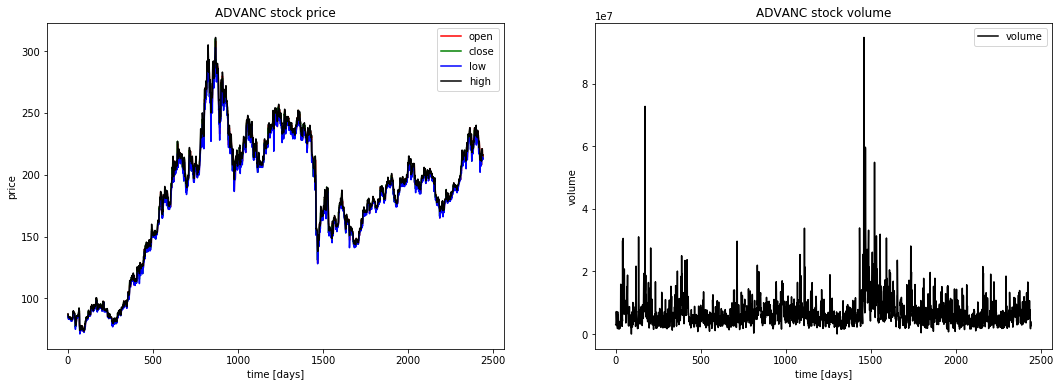

In [45]:
plt.figure(figsize=(18, 6));
plt.subplot(1,2,1);
plt.plot(stock_data[0]['Open'].values, color='red', label='open')
plt.plot(stock_data[0]['Close'].values, color='green', label='close')
plt.plot(stock_data[0]['Low'].values, color='blue', label='low')
plt.plot(stock_data[0]['High'].values, color='black', label='high')
plt.title('ADVANC stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(stock_data[0]['Volume'].values, color='black', label='volume')
plt.title('ADVANC stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
 
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น

stock_data[0] = stock_data[0].drop('Close',axis=1)
dataset = stock_data[0]
values = dataset.values
values = values.astype('float32')

# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง

min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้

reframed = series_to_supervised(dataset.values, 90, 3,feat_name=stock_data[0].columns)
reframed.drop(['High(t)','High(t+1)','High(t+2)','Low(t)','Low(t+1)','Low(t+2)','Open(t)','Open(t+1)','Open(t+2)','Volume(t)','Volume(t+1)',\
               'Volume(t+2)'],axis=1,inplace=True)

In [48]:
values = reframed.values
n_train_percent = 0.9
split = int(values.shape[0]*0.9)
train = values[:split, :]
test = values[split:, :]

In [49]:
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:split]
date_test = date_reframed[split:]

In [50]:
X_train, y_train = train[:, :-3], train[:, -3:]
X_test, y_test = test[:, :-3], test[:, -3:]


# reshape input to be 3D [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [51]:
X_train

array([[[0.05894737, 0.06040992, 0.05944798, ..., 0.00636943,
         0.02206607, 0.0054912 ]],

       [[0.05789474, 0.06256742, 0.0626327 , ..., 0.00636943,
         0.03591066, 0.00627569]],

       [[0.05263158, 0.05717368, 0.05732484, ..., 0.01167728,
         0.        , 0.00627569]],

       ...,

       [[0.54105263, 0.55124056, 0.53927813, ..., 0.44798301,
         0.03865151, 0.65262059]],

       [[0.54105263, 0.55555556, 0.54989384, ..., 0.44373673,
         0.02549925, 0.65511338]],

       [[0.54947368, 0.55987055, 0.55414013, ..., 0.44798301,
         0.04682655, 0.66009914]]])

In [52]:
X_test

array([[[0.54947368, 0.55555556, 0.55414013, ..., 0.45010616,
         0.08669492, 0.63766348]],

       [[0.54526316, 0.55555556, 0.54140127, ..., 0.42887473,
         0.20172387, 0.61273501]],

       [[0.54526316, 0.55987055, 0.54564756, ..., 0.40127389,
         0.08239632, 0.61273501]],

       ...,

       [[0.64210526, 0.64185545, 0.64755839, ..., 0.61783439,
         0.06469429, 0.90698641]],

       [[0.61263158, 0.62028047, 0.62208068, ..., 0.62632696,
         0.07261181, 0.88114931]],

       [[0.61263158, 0.60733549, 0.60084926, ..., 0.59660297,
         0.02557841, 0.88114931]]])

In [53]:
reframed.head(10)

,High(t-90),Low(t-90),Open(t-90),Volume(t-90),Adj Close(t-90),High(t-89),Low(t-89),Open(t-89),Volume(t-89),Adj Close(t-89),High(t-88),Low(t-88),Open(t-88),Volume(t-88),Adj Close(t-88),High(t-87),Low(t-87),Open(t-87),Volume(t-87),Adj Close(t-87),High(t-86),Low(t-86),Open(t-86),Volume(t-86),Adj Close(t-86),High(t-85),Low(t-85),Open(t-85),Volume(t-85),Adj Close(t-85),High(t-84),Low(t-84),Open(t-84),Volume(t-84),Adj Close(t-84),High(t-83),Low(t-83),Open(t-83),Volume(t-83),Adj Close(t-83),High(t-82),Low(t-82),Open(t-82),Volume(t-82),Adj Close(t-82),High(t-81),Low(t-81),Open(t-81),Volume(t-81),Adj Close(t-81),High(t-80),Low(t-80),Open(t-80),Volume(t-80),Adj Close(t-80),High(t-79),Low(t-79),Open(t-79),Volume(t-79),Adj Close(t-79),High(t-78),Low(t-78),Open(t-78),Volume(t-78),Adj Close(t-78),High(t-77),Low(t-77),Open(t-77),Volume(t-77),Adj Close(t-77),High(t-76),Low(t-76),Open(t-76),Volume(t-76),Adj Close(t-76),High(t-75),Low(t-75),Open(t-75),Volume(t-75),Adj Close(t-75),High(t-74),Low(t-74),Open(t-74),Volume(t-74),Adj Close(t-74),High(t-73),Low(t-73),Open(t-73),Volume(t-73),Adj Close(t-73),High(t-72),Low(t-72),Open(t-72),Volume(t-72),Adj Close(t-72),High(t-71),Low(t-71),Open(t-71),Volume(t-71),Adj Close(t-71),High(t-70),Low(t-70),Open(t-70),Volume(t-70),Adj Close(t-70),High(t-69),Low(t-69),Open(t-69),Volume(t-69),Adj Close(t-69),High(t-68),Low(t-68),Open(t-68),Volume(t-68),Adj Close(t-68),High(t-67),Low(t-67),Open(t-67),Volume(t-67),Adj Close(t-67),High(t-66),Low(t-66),Open(t-66),Volume(t-66),Adj Close(t-66),High(t-65),Low(t-65),Open(t-65),Volume(t-65),Adj Close(t-65),High(t-64),Low(t-64),Open(t-64),Volume(t-64),Adj Close(t-64),High(t-63),Low(t-63),Open(t-63),Volume(t-63),Adj Close(t-63),High(t-62),Low(t-62),Open(t-62),Volume(t-62),Adj Close(t-62),High(t-61),Low(t-61),Open(t-61),Volume(t-61),Adj Close(t-61),High(t-60),Low(t-60),Open(t-60),Volume(t-60),Adj Close(t-60),High(t-59),Low(t-59),Open(t-59),Volume(t-59),Adj Close(t-59),High(t-58),Low(t-58),Open(t-58),Volume(t-58),Adj Close(t-58),High(t-57),Low(t-57),Open(t-57),Volume(t-57),Adj Close(t-57),High(t-56),Low(t-56),Open(t-56),Volume(t-56),Adj Close(t-56),High(t-55),Low(t-55),Open(t-55),Volume(t-55),Adj Close(t-55),High(t-54),Low(t-54),Open(t-54),Volume(t-54),Adj Close(t-54),High(t-53),Low(t-53),Open(t-53),Volume(t-53),Adj Close(t-53),High(t-52),Low(t-52),Open(t-52),Volume(t-52),Adj Close(t-52),High(t-51),Low(t-51),Open(t-51),Volume(t-51),Adj Close(t-51),High(t-50),Low(t-50),Open(t-50),Volume(t-50),Adj Close(t-50),High(t-49),Low(t-49),Open(t-49),Volume(t-49),Adj Close(t-49),High(t-48),Low(t-48),Open(t-48),Volume(t-48),Adj Close(t-48),High(t-47),Low(t-47),Open(t-47),Volume(t-47),Adj Close(t-47),High(t-46),Low(t-46),Open(t-46),Volume(t-46),Adj Close(t-46),High(t-45),Low(t-45),Open(t-45),Volume(t-45),Adj Close(t-45),High(t-44),Low(t-44),Open(t-44),Volume(t-44),Adj Close(t-44),High(t-43),Low(t-43),Open(t-43),Volume(t-43),Adj Close(t-43),High(t-42),Low(t-42),Open(t-42),Volume(t-42),Adj Close(t-42),High(t-41),Low(t-41),Open(t-41),Volume(t-41),Adj Close(t-41),High(t-40),Low(t-40),Open(t-40),Volume(t-40),Adj Close(t-40),High(t-39),Low(t-39),Open(t-39),Volume(t-39),Adj Close(t-39),High(t-38),Low(t-38),Open(t-38),Volume(t-38),Adj Close(t-38),High(t-37),Low(t-37),Open(t-37),Volume(t-37),Adj Close(t-37),High(t-36),Low(t-36),Open(t-36),Volume(t-36),Adj Close(t-36),High(t-35),Low(t-35),Open(t-35),Volume(t-35),Adj Close(t-35),High(t-34),Low(t-34),Open(t-34),Volume(t-34),Adj Close(t-34),High(t-33),Low(t-33),Open(t-33),Volume(t-33),Adj Close(t-33),High(t-32),Low(t-32),Open(t-32),Volume(t-32),Adj Close(t-32),High(t-31),Low(t-31),Open(t-31),Volume(t-31),Adj Close(t-31),High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),High(t-25),Low(t-25),Open(t-25),Vo

In [54]:
# เทรนโมเดล

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

In [55]:
# ลองรัน

history = model.fit(X_train,y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 2114 samples, validate on 235 samples
Epoch 1/100
2114/2114 - 8s - loss: 0.1027 - val_loss: 0.0674
Epoch 2/100
2114/2114 - 1s - loss: 0.0962 - val_loss: 0.0944
Epoch 3/100
2114/2114 - 1s - loss: 0.0835 - val_loss: 0.0628
Epoch 4/100
2114/2114 - 1s - loss: 0.0873 - val_loss: 0.0750
Epoch 5/100
2114/2114 - 1s - loss: 0.0706 - val_loss: 0.0527
Epoch 6/100
2114/2114 - 1s - loss: 0.0664 - val_loss: 0.0834
Epoch 7/100
2114/2114 - 1s - loss: 0.0657 - val_loss: 0.0549
Epoch 8/100
2114/2114 - 1s - loss: 0.0595 - val_loss: 0.0952
Epoch 9/100
2114/2114 - 1s - loss: 0.0606 - val_loss: 0.0563
Epoch 10/100
2114/2114 - 1s - loss: 0.0553 - val_loss: 0.0931
Epoch 11/100
2114/2114 - 1s - loss: 0.0621 - val_loss: 0.0773
Epoch 12/100
2114/2114 - 1s - loss: 0.0505 - val_loss: 0.0824
Epoch 13/100
2114/2114 - 1s - loss: 0.0511 - val_loss: 0.0788
Epoch 14/100
2114/2114 - 1s - loss: 0.0537 - val_loss: 0.0902
Epoch 15/100
2114/2114 - 1s - loss: 0.0511 - val_loss: 0.0760
Epoch 16/100
2114/2114 - 1s - lo

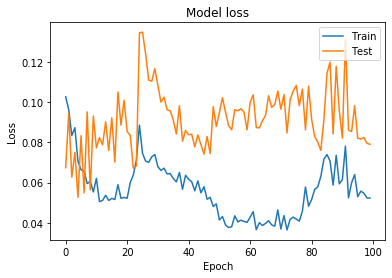

In [56]:
# กราฟ

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [57]:
# ทำนายผล

yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [58]:
inv_yhat = yhat*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
inv_y = y_test*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']

(array([737150., 737180., 737211., 737241., 737272.]),
 <a list of 5 Text xticklabel objects>)

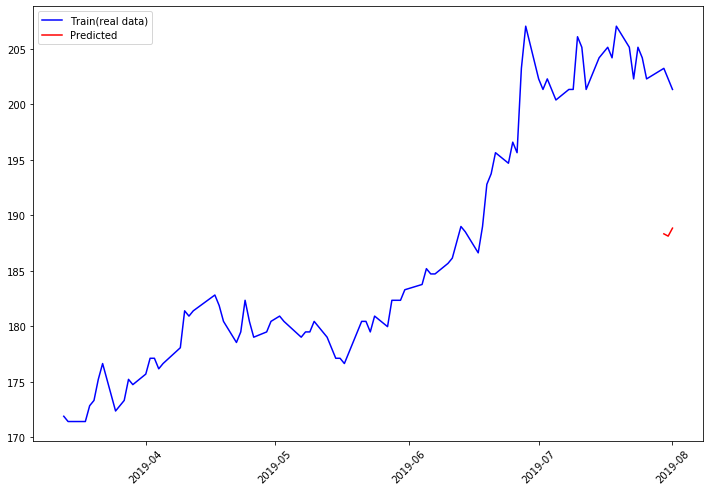

In [61]:
# เปรียบเทียบราคาจริง กับที่ทำนายไว้ โดยทำการเทรนด้วยข้อมูลย้อนหลัง 90 วัน และทำนายผลล่วงหน้า 3 วัน

idx = np.random.randint(0,len(yhat-3))
if idx <90:
  date_actual = date_test[:idx+3]
else:
  date_actual = date_test[idx-90:idx+3]

plt.figure(figsize=(12,8))

_=plt.plot(date_actual,inv_y[max(0,idx-90):idx+3,0],'b')
_=plt.plot(date_test[idx:idx+3],inv_yhat[idx],'r')

plt.legend(['Train(real data)', 'Predicted'], loc='upper left')

plt.xticks(rotation=45)

In [62]:
# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.262
